In [2]:
using Revise
import NMR
import Plots

HMDB initialised from /home/mu3q/Source/NMR.jl/src
Module NMR v0.9.0
(c)mu 2018-2025


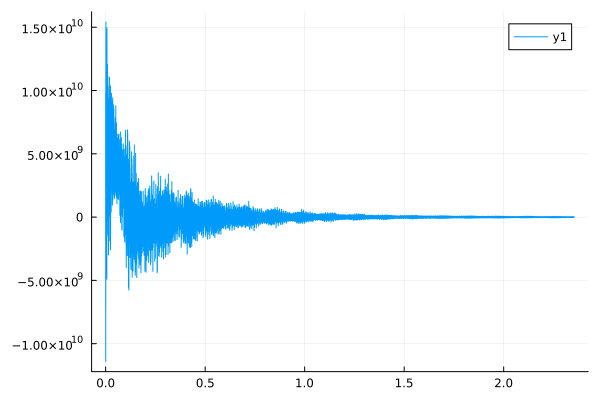

In [3]:
f=NMR.readBrukerFID("./test/data/10/fid")
acqus=NMR.readBrukerParameterFile("./test/data/10/acqus")
dwellTime=1/acqus["SW_h"]
f=f[74:end]
d=NMR.Data1D(f,0.0,length(f)*dwellTime)
Plots.plot(real(d))

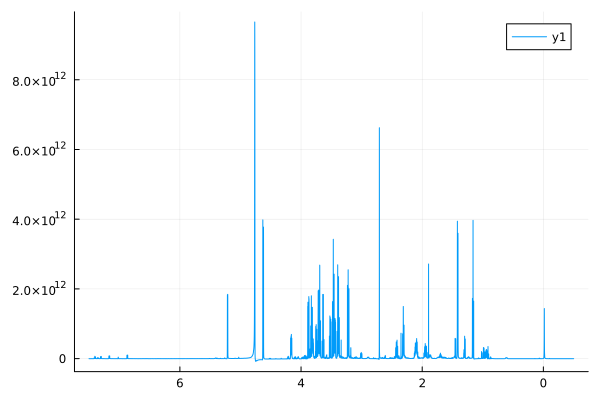

In [4]:
spect=NMR.FourierTransform(d,PPM=acqus["SFO1"],CTR=4.76) |> NMR.AutoPhaseCorrectChen |> x->NMR.cut(x,-0.5,7.5)
Plots.plot(spect,xaxis=:flip)

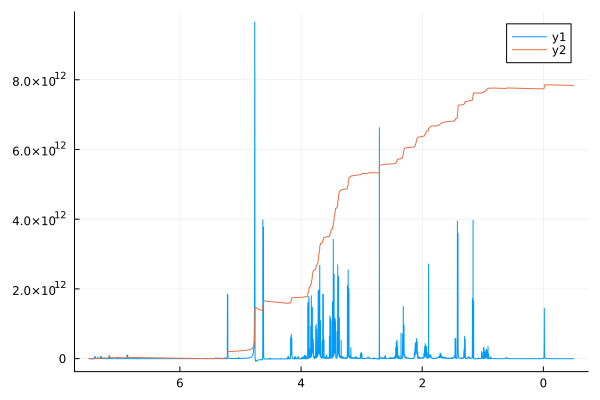

In [5]:
intSpect = NMR.integrate(spect,flip=true)
Plots.plot!(20*intSpect)

In [ ]:
NMR.medianBaseline(real(spect))

## Experiments for NMR Data Structure

The NMR data structure should be
- able to hold NMR data of any number of dimensions
- allow efficient calculations
- be compatible with any style of numerical array, including sparse arrays
- cleanly interface with `LinearAlgebra`, `DataFrames`, `CUDA`, and `Flux` packages
- allow integer indexing (like a matrix) to access indvidual data points
- provide a mechanism for conversion of indices to and from axes


In [26]:
struct TestArray{T,N} <: AbstractArray{T,N}
    dat::AbstractArray{T,N}
    params::Dict{Symbol,Any}
    ind

    function TestArray(A::AbstractArray{T,N},p::Dict{Symbol,<:Any},indx::Vararg{Any,N}) where {T,N}
        return new{T,N}(A,p,indx)
    end
end

Base.size(A::TestArray{T,N}) where {T,N}  = size(A.dat)
Base.getindex(A::TestArray{T,N},i::Integer) where {T,N} = getindex(A.dat,i)
Base.getindex(A::TestArray{T,N},r::Real) where {T,N} = getindex(A.dat,convert(Int64,round(r)))
Base.IndexStyle(A::TestArray{T,N}) where {T,N} = IndexStyle(A.dat)

function Base.show(io::IO,fmt::MIME,A::TestArray{T,N} where {T,N})
    show(io, fmt, A.dat)
    show(io,fmt,A.params)
end

function Base.display(A::TestArray{T,N} ) where {T,N}
    display("TestArray{$T,$N}")
    display(A.dat)
    display(A.params)
end

import Base.+
+(A::TestArray{T,N},B::TestArray{T2,N2}) where {T,N,T2,N2} = TestArray(A.dat+B.dat,merge(A.params,B.params),A.ind...)
+(A::TestArray{T,N},B::AbstractArray{T2,N2}) where {T,N,T2,N2} = TestArray(A.dat+B,A.params,A.ind...)
+(B::AbstractArray{T2,N2},A::TestArray{T,N}) where {T,N,T2,N2} = TestArray(A.dat+B,A.params,A.ind...)

+ (generic function with 192 methods)

In [34]:
A = TestArray([1 2 3 ; 4 5 6],Dict(:hello=>"Greetings"),[199,250],[3,4])
B = TestArray([1 2 3 ; 4 5 6],Dict(:hello=>"Greetings"),0:0.1:50,0:0.1:50)

"TestArray{Int64,2}"

2×3 Matrix{Int64}:
 1  2  3
 4  5  6

Dict{Symbol, Any} with 1 entry:
  :hello => "Greetings"

In [28]:
A+B

"TestArray{Int64,2}"

2×3 Matrix{Int64}:
 2   4   6
 8  10  12

Dict{Symbol, Any} with 1 entry:
  :hello => "Greetings"

In [29]:
A+[4 5 5 ; 7 -8 9]

"TestArray{Int64,2}"

2×3 Matrix{Int64}:
  5   7   8
 11  -3  15

Dict{Symbol, Any} with 1 entry:
  :hello => "Greetings"

In [2]:
[4 5 5; 7 -9 9]+A

UndefVarError: UndefVarError: `A` not defined

## CUDA

It is straightforward to convert such data objects into CuArrays:

In [31]:
using CUDA
Acu=CuArray(A)

2×3 CuArray{Int64, 2, CUDA.DeviceMemory}:
 1  2  3
 4  5  6

In [32]:
display(A)

"TestArray{Int64,2}"

2×3 Matrix{Int64}:
 1  2  3
 4  5  6

Dict{Symbol, Any} with 1 entry:
  :hello => "Greetings"

However, using CuArrays in TestArrays is also possible. 

In [41]:
cA = TestArray(CuArray(Float32.([3.4 55 ; 44 33])),Dict(:param=>"Hello"),0:0.1:50,0:0.1:50)

"TestArray{Float32,2}"

2×2 CuArray{Float32, 2, CUDA.DeviceMemory}:
  3.4  55.0
 44.0  33.0

Dict{Symbol, Any} with 1 entry:
  :param => "Hello"

In [13]:
A+cA

UndefVarError: UndefVarError: `A` not defined

## Sparse Arrays

In [14]:
using SparseArrays
sA=sparse(A)

UndefVarError: UndefVarError: `A` not defined

In [15]:
sA=TestArray{Float64,2}(sA,Dict(:hello=>"bingo"))

UndefVarError: UndefVarError: `sA` not defined

In [16]:
sA+B

UndefVarError: UndefVarError: `sA` not defined

In [17]:
achse=0.5:0.01:1.0

0.5:0.01:1.0

In [18]:
achse[47]

0.96

## Index and Axis conversion

In [19]:
function index(R::AbstractRange,x::Real)
    ix=divrem(x-first(R),step(R))
    return (1+floor(Int,ix[1]),ix[2]/step(R))
end

index (generic function with 1 method)

In [20]:
@time i,r=index(0.1:0.1:4,0.24)

  0.000004 seconds (2 allocations: 32 bytes)


(2, 0.3999999999999998)